<a href="https://colab.research.google.com/github/aflores/my-binder-notebooks/blob/main/ch03-highlights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 
# Notes from Chapter 3 - Linear Regression and Beyond
#
# - Linear regression - Done by calculate a weih ('w') by minimizing a cost function (square of difference)
# - Polynomial regression
# - Regularization - A technique to produce smaller coefficient vectors by adding a penalty to larger norm values
#

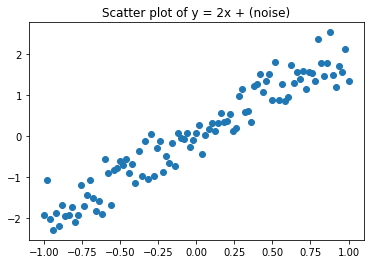

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

x_train = np.linspace(-1, 1, 101)
y_train = 2 * x_train + np.random.randn(*x_train.shape) * 0.33

plt.title("Scatter plot of y = 2x + (noise)")
plt.scatter(x_train, y_train)
plt.show()


# Linear Regression

Find the value of 'w' such that the cost function is minimal

In [3]:
learning_rate = 0.01
training_epochs = 100

In [4]:
X = tf.constant(x_train, dtype=tf.float32)
Y = tf.constant(y_train, dtype=tf.float32)
w = tf.Variable(0., name="weights", dtype=tf.float32)

cost = lambda: tf.square(Y - tf.multiply(X, w))

In [5]:
train_op = tf.keras.optimizers.SGD(learning_rate)

for _ in range(training_epochs):
    step_count = train_op.minimize(cost, w)
    # print(w.numpy())

In [6]:
val1 = w.value()
print("Prediction: {}".format(val1))

Prediction: 2.045654296875


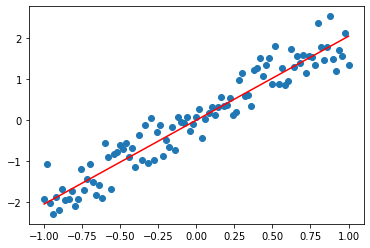

In [7]:
plt.scatter(x_train, y_train)

# plot the line with based on the predicted value of w
y_learned = x_train * val1

plt.plot(x_train, y_learned, 'r')
plt.show()

# Polynomial Model

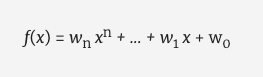

In [8]:
learning_rate = 0.0085

# "momentum" accelerates gradient descent in the 
# relevant direction and dampens oscillations.
# Used for the Keras gradient descent implementation
momentum = 0.5
training_epochs = 40

In [9]:
trX = np.linspace(-1, 1, 101)
iterations = 0
num_coeffs = 6
trY_coeffs = [1, 2, 3, 4, 5, 6]
trY = 0

In [10]:
for i in range(num_coeffs):
    trY += trY_coeffs[i] * np.power(trX, i)
trY += np.random.randn(*trX.shape) * 1.5

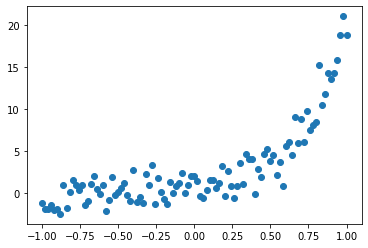

In [11]:
plt.scatter(trX, trY)
plt.show()

In [12]:
X = tf.constant(trX, dtype=tf.float32)
Y = tf.constant(trY, dtype=tf.float32)
w = tf.Variable([0.] * num_coeffs, name='parameters')

In [13]:
model = lambda _X, _w: tf.add_n([tf.multiply(_w[i], tf.pow(_X, i)) for i in range(num_coeffs)])
y_model = lambda: model(X, w)
cost = lambda: tf.pow(Y - y_model(), 2)

In [14]:
train_op = tf.keras.optimizers.SGD(learning_rate, momentum=momentum)

In [15]:
for _ in range(training_epochs):
    step = train_op.minimize(cost, w)
w_val = w.value()

print("Weights after training: \n")
print(w_val.numpy())

Weights after training: 

[0.75927836 1.7194377  3.7986846  4.337435   4.3411765  5.0913806 ]


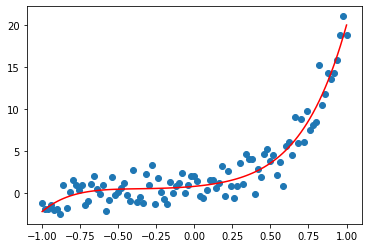

In [16]:
plt.scatter(trX, trY)
trY2 = 0

for i in range(num_coeffs):
    trY2 += w_val[i] * np.power(trX, i)
    
plt.plot(trX, trY2, 'r')
plt.show()

## Regularization



In [17]:
# here is a hand written function to split a dataset into testing and training sets
# this is equivalent to sklearn.model.selection.train_test_split
# 
# x_dataset and y_dataset are np.array, ratio is the fraction to be used for the training data ( .7 = 70%)
def split_dataset(x_dataset, y_dataset, ratio):
    arr = np.arange(x_dataset.size)
    np.random.shuffle(arr)
    num_train = int(ratio * x_dataset.size)
    x_train = x_dataset[arr[0:num_train]]
    x_test = x_dataset[arr[num_train:x_dataset.size]]
    y_train = y_dataset[arr[0:num_train]]
    y_test = y_dataset[arr[num_train:x_dataset.size]]
    return x_train, x_test, y_train, y_test

x_sample = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
y_sample = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

split_dataset(x_sample,y_sample, .7)

(array([10,  3,  9,  1,  7,  5,  6]),
 array([8, 2, 4]),
 array([100,  30,  90,  10,  70,  50,  60]),
 array([80, 20, 40]))

In [18]:
learning_rate = 0.001
training_epochs = 1000
reg_lambda = float(0)
num_coeffs = 9

In [19]:
x_dataset = np.linspace(-1, 1, 100)

In [20]:
y_dataset_params = [0.] * num_coeffs
y_dataset_params[2] = 1
y_dataset = 0
for i in range(num_coeffs):
    y_dataset += y_dataset_params[i] * np.power(x_dataset, i)
y_dataset += np.random.randn(*x_dataset.shape) * 0.3

In [21]:
(x_train, x_test, y_train, y_test) = split_dataset(x_dataset, y_dataset, 0.7)

In [22]:
X = tf.constant(x_train, dtype=tf.float32)
Y = tf.constant(y_train, dtype=tf.float32)
w = tf.Variable([0.] * num_coeffs, name='parameters', dtype=tf.float32)

In [23]:
@tf.function
def model(X, w):
    terms = []
    for i in range(num_coeffs):
        term = tf.multiply(w[i], tf.pow(X, i))
        terms.append(term)    
    return tf.add_n(terms)

In [24]:
@tf.function
def y_model():
    return model(X, w)

In [25]:
@tf.function
def cost():
    w_sqr = tf.square(w)
    w_red = tf.reduce_sum(w_sqr)
    m_lmd_w_sqr = tf.multiply(tf.convert_to_tensor(reg_lambda, dtype=tf.float32), w_red)
    y_y_model_sqr = tf.reduce_sum(tf.square(Y-y_model()))
    sum_y_model_sqr_reglambda_w_sqr = tf.add(y_y_model_sqr, m_lmd_w_sqr)
    return tf.math.divide(sum_y_model_sqr_reglambda_w_sqr, 2*x_train.size)

In [26]:
train_op = tf.keras.optimizers.SGD(learning_rate)

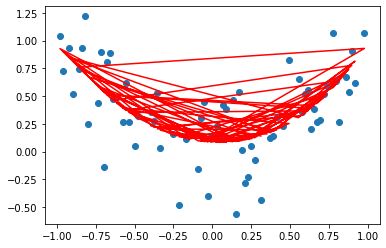

reg lambda 0.0
final cost tf.Tensor(
[ 0.08383133 -0.06507747  0.76043874  0.00556708  0.2237492   0.01579039
 -0.01448012  0.05232311 -0.09336247], shape=(9,), dtype=float32)


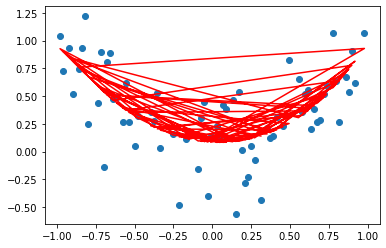

reg lambda 2.2222222222222223
final cost tf.Tensor(
[ 0.08360166 -0.06501041  0.76186925  0.00547328  0.22343628  0.01564696
 -0.01531375  0.05242742 -0.09410273], shape=(9,), dtype=float32)


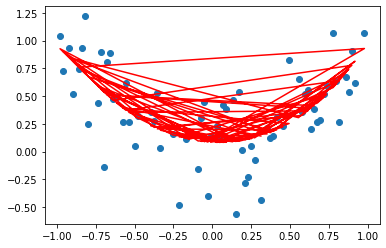

reg lambda 4.444444444444445
final cost tf.Tensor(
[ 0.08337174 -0.06494336  0.7632938   0.00537968  0.2231177   0.01550369
 -0.01614029  0.05253173 -0.09483116], shape=(9,), dtype=float32)


In [34]:
iters = 0
for reg_lambda in np.linspace(0, 1, 30):
    iters += 1
    for epoch in range(training_epochs):
        train_op.minimize(cost, w)
    final_cost = w.value()
    
    # Print the first 3 attempts (for illustration)
    if iters in range(4):
        plt.scatter(x_train, y_train)

        y1 = 0
        for i in range(num_coeffs):
            y1 += final_cost[i] * np.power(X, i)

        plt.plot(x_train, y1, 'r')
        plt.show()
        
        print('reg lambda', reg_lambda)
        print('final cost', final_cost)


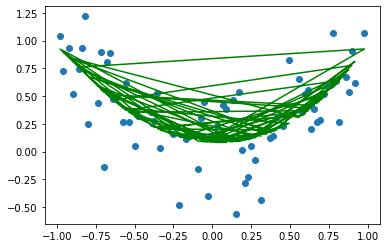

Final result
reg lambda 20.0
final cost tf.Tensor(
[ 0.08186671 -0.06447397  0.7727008   0.00472999  0.22092722  0.01451186
 -0.02168922  0.05326188 -0.09960505], shape=(9,), dtype=float32)


In [35]:
plt.scatter(x_train, y_train)

y1 = 0
for i in range(num_coeffs):
    y1 += final_cost[i] * np.power(X, i)

plt.plot(x_train, y1, 'g')
plt.show()
print("Final result")
print('reg lambda', reg_lambda)
print('final cost', final_cost)